<a href="https://colab.research.google.com/github/sergio-qp/AP_2_SQ_AG/blob/master/Proyect_2_draft%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb





In [5]:

uploaded=files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

Saving attrition_availabledata_02.csv to attrition_availabledata_02.csv


In [ ]:
print(data.head())

         hrs  absences  JobInvolvement  PerformanceRating  \
0  10.060048       6.0             3.0                4.0   
1   9.437671       2.0             2.0                3.0   
2   7.900932      20.0             3.0                4.0   
3   7.193853      19.0             4.0                3.0   
4   6.979201       8.0             3.0                3.0   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
0                      2.0              4.0              1.0  31.0   
1                      3.0              4.0              3.0  33.0   
2                      3.0              4.0              3.0  35.0   
3                      4.0              2.0              3.0  28.0   
4                      2.0              4.0              2.0  31.0   

      BusinessTravel              Department  ...  MonthlyIncome  \
0  Travel_Frequently  Research & Development  ...        65000.0   
1         Non-Travel  Research & Development  ...        63850.0   
2      T

In [6]:

# General Information
num_rows = len(data)  # Number of rows
num_columns = len(data.columns)  # Number of columns

# Column Types
column_types = data.dtypes  # Data types of the columns
column_info = {}
for dtype in column_types.unique():
    column_info[str(dtype)] = sum(column_types == dtype)

# Identify categorical and numerical variables
categorical_vars = [col for col in data.columns if data[col].dtype == 'object']
numerical_vars = [col for col in data.columns if data[col].dtype in ['int64', 'float64']]

# Cardinality of categorical variables
categorical_cardinality = {}
for col in categorical_vars:
    categorical_cardinality[col] = data[col].nunique()

# Missing Values
if data.isnull().sum().sum() > 0:
    missing_values = "There are missing values"
else:
    missing_values = "There are no missing values"

# Constant Columns
constant_columns = [col for col in data.columns if data[col].nunique() == 1]
print(f"Constant Columns Removed: {constant_columns}")

# ID Columns
possible_id_columns = []
for col in data.columns:
    if data[col].nunique() == num_rows:
        possible_id_columns.append(col)

# Problem Type (Regression or Classification)
target_variable = data.columns[-1]  # Last column as target
if data[target_variable].nunique() <= 10:
    target_type = 'classification'
else:
    target_type = 'regression'

# Class Distribution (if classification)
if target_type == 'classification':
    class_counts = data[target_variable].value_counts()  # Count each class
    total_counts = len(data[target_variable])  # Total rows
    class_distribution = class_counts / total_counts  # Proportion of each class

    # Check if the dataset is imbalanced
    is_imbalanced = class_distribution.max() > 0.6  # Use .max() with parentheses
else:
    class_distribution = None
    is_imbalanced = None

# EDA Summary
eda_summary = {
    "Number of Rows": num_rows,
    "Number of Columns": num_columns,
    "Column Types": column_info,
    "Categorical Variables": categorical_vars,
    "Numerical Variables": numerical_vars,
    "Categorical Variables Table": pd.DataFrame({
        "Variable": categorical_vars,
        "Cardinality": [categorical_cardinality[col] for col in categorical_vars]
    }),
    "Missing Values": missing_values,
    "Removed Constant Columns": constant_columns,
    "Possible ID Columns": possible_id_columns,
    "Problem Type": target_type,
    "Class Distribution (if classification)": class_distribution,
    "Is Imbalanced": is_imbalanced,
}

for key, value in eda_summary.items():
    print(f"{key}: {value}")




Constant Columns Removed: ['EmployeeCount', 'Over18', 'StandardHours']
Number of Rows: 2940
Number of Columns: 31
Column Types: {'float64': 23, 'object': 8}
Categorical Variables: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']
Numerical Variables: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical Variables Table:          Variable  Cardinality
0  BusinessTravel            3
1      Department            3
2  EducationField            6
3          Gender            2
4         JobRole            9
5   MaritalStatus            3
6          Over18     

The dataset contains 2940 rows and 31 columns. Of these 31 variables, 23 are numerical variables, and 8 are categorical variables. These categorical variables include: BusinessTravel, Department, or Gender. They have different values; for example, Gender has two unique values: "Female" and "Male." On the other hand, there are other categorical variables, such as JobRole, which have 9 unique values, indicating different roles like Sales Executive or Manager.

Before performing any statistical analysis, it is crucial to check if the dataset contains missing values, as they can cause errors. As observed, the dataset does not have any missing values. Similarly, it is essential to verify if there are variables that have the same value across all observations, as these variables could be removed. In this dataset, Over18, EmployeeCount, and StandardHours are constant variables, which do not provide any useful information and should be eliminated.

To determine whether we have a classification or regression problem, it is necessary to identify our target variable. The target variable is Attrition, whose unique values are "Yes" and "No." Therefore, as it is a categorical variable, this is a classification problem.

The target variable presents significant imbalance, with 83% of the observations corresponding to employees who do not leave ("No") and 16% belonging to the "Yes" category.

In [7]:
# Remove constant columns from the DataFrame
data = data.drop(columns=constant_columns)

# Display the removed columns
print(f"Constant Columns Removed: {constant_columns}")

# Update and display the new number of rows and columns
num_rows = len(data)
num_columns = len(data.columns)

print(f"Updated DataFrame: {num_rows} rows and {num_columns} columns.")
print(data.head())


Constant Columns Removed: ['EmployeeCount', 'Over18', 'StandardHours']
Updated DataFrame: 2940 rows and 28 columns.
         hrs  absences  JobInvolvement  PerformanceRating  \
0  10.060048       6.0             3.0                4.0   
1   9.437671       2.0             2.0                3.0   
2   7.900932      20.0             3.0                4.0   
3   7.193853      19.0             4.0                3.0   
4   6.979201       8.0             3.0                3.0   

   EnvironmentSatisfaction  JobSatisfaction  WorkLifeBalance   Age  \
0                      2.0              4.0              1.0  31.0   
1                      3.0              4.0              3.0  33.0   
2                      3.0              4.0              3.0  35.0   
3                      4.0              2.0              3.0  28.0   
4                      2.0              4.0              2.0  31.0   

      BusinessTravel              Department  ...  MonthlyIncome  \
0  Travel_Frequently  Resear

In [8]:
#SET UP
# Separate features (X) and target variable (y)
X = data.drop(columns=['Attrition'])  # Drop target variable
y = data['Attrition'].replace({'No': 0, 'Yes': 1})
print(y.value_counts())

# Division de los datos
# Split the dataset into training and testing sets (80/20 split)
seed = 123456  # Set a fixed seed for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)



Attrition
0    2466
1     474
Name: count, dtype: int64


<ipython-input-8-27ca964790e0>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = data['Attrition'].replace({'No': 0, 'Yes': 1})


The Holdout method involves splitting the dataset into training and test sets. In this case, 80% of the observations were assigned to the training set, and 20% to the test set.

Holdout was used because it simulates the model's effectiveness on completely new data. Additionally, since the target variable is imbalanced, it is essential to maintain the proportion of classes in both samples to ensure that one sample does not contain only one class of the target variable.

In [9]:

# Step 1: Identify categorical and numerical columns
# This separates the features into categorical and numerical types for preprocessing.
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()  # List of categorical columns
numerical_vars = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # List of numerical columns

# Step 2: Create a preprocessor
# A ColumnTransformer is used to apply different transformations to categorical and numerical columns.
# - Categorical: OneHotEncoder to convert categories into binary columns.
# - Numerical: 'passthrough' means numerical columns are not transformed.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_vars),  # Transform categorical variables
        ('num', 'passthrough', numerical_vars)  # Keep numerical variables as is
    ]
)

# Method 1: Dummy Classifier (Baseline)
# A simple classifier that always predicts the most frequent class. This is used as a baseline for comparison.
start_dummy = time.time()  # Start timing
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)  # Most frequent strategy
dummy_clf.fit(X_train, y_train)  # Train on the training data
dummy_preds = dummy_clf.predict(X_test)  # Predict on the test data
dummy_acc = accuracy_score(y_test, dummy_preds)  # Calculate accuracy
dummy_bal_acc = balanced_accuracy_score(y_test, dummy_preds)  # Calculate balanced accuracy
dummy_time = time.time() - start_dummy  # End timing

# Method 2: Decision Tree with Pipeline
# Combines the preprocessor and a Decision Tree model into a single pipeline for clean and efficient workflow.
start_tree = time.time()  # Start timing
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing to the data
    ('classifier', DecisionTreeClassifier(random_state=42))  # Train a Decision Tree classifier
])
tree_pipeline.fit(X_train, y_train)  # Train the pipeline
tree_preds = tree_pipeline.predict(X_test)  # Predict using the trained pipeline
tree_acc = accuracy_score(y_test, tree_preds)  # Calculate accuracy
tree_bal_acc = balanced_accuracy_score(y_test, tree_preds)  # Calculate balanced accuracy
tree_time = time.time() - start_tree  # End timing

# Method 3: KNN with StandardScaler
# Combines preprocessing, scaling (StandardScaler), and KNN model into a single pipeline.
start_knn_std = time.time()  # Start timing
knn_pipeline_std = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('scaler', StandardScaler()),  # Scale features to have mean=0 and std=1
    ('classifier', KNeighborsClassifier())  # Train a KNN classifier
])
knn_pipeline_std.fit(X_train, y_train)  # Train the pipeline
knn_std_preds = knn_pipeline_std.predict(X_test)  # Predict using the trained pipeline
knn_std_acc = accuracy_score(y_test, knn_std_preds)  # Calculate accuracy
knn_std_bal_acc = balanced_accuracy_score(y_test, knn_std_preds)  # Calculate balanced accuracy
knn_std_time = time.time() - start_knn_std  # End timing

# Method 4: KNN with MinMaxScaler
# Similar to the StandardScaler pipeline, but uses MinMaxScaler for scaling.
start_knn_minmax = time.time()  # Start timing
knn_pipeline_minmax = Pipeline([
    ('preprocessor', preprocessor),  # Apply preprocessing
    ('scaler', MinMaxScaler()),  # Scale features to range [0, 1]
    ('classifier', KNeighborsClassifier())  # Train a KNN classifier
])
knn_pipeline_minmax.fit(X_train, y_train)  # Train the pipeline
knn_minmax_preds = knn_pipeline_minmax.predict(X_test)  # Predict using the trained pipeline
knn_minmax_acc = accuracy_score(y_test, knn_minmax_preds)  # Calculate accuracy
knn_minmax_bal_acc = balanced_accuracy_score(y_test, knn_minmax_preds)  # Calculate balanced accuracy
knn_minmax_time = time.time() - start_knn_minmax  # End timing

# Step 5: Display results
# Print the performance metrics (Accuracy and Balanced Accuracy) for all models.
# Additionally, display the time taken for each model.
print("Results:")
print(f"Dummy Classifier - Accuracy: {dummy_acc:.2f}, Balanced Accuracy: {dummy_bal_acc:.2f}, Time: {dummy_time:.2f}s")
print(f"Decision Tree - Accuracy: {tree_acc:.2f}, Balanced Accuracy: {tree_bal_acc:.2f}, Time: {tree_time:.2f}s")
print(f"KNN (StandardScaler) - Accuracy: {knn_std_acc:.2f}, Balanced Accuracy: {knn_std_bal_acc:.2f}, Time: {knn_std_time:.2f}s")
print(f"KNN (MinMaxScaler) - Accuracy: {knn_minmax_acc:.2f}, Balanced Accuracy: {knn_minmax_bal_acc:.2f}, Time: {knn_minmax_time:.2f}s")




Results:
Dummy Classifier - Accuracy: 0.84, Balanced Accuracy: 0.50, Time: 0.01s
Decision Tree - Accuracy: 0.92, Balanced Accuracy: 0.84, Time: 0.06s
KNN (StandardScaler) - Accuracy: 0.86, Balanced Accuracy: 0.66, Time: 0.07s
KNN (MinMaxScaler) - Accuracy: 0.86, Balanced Accuracy: 0.67, Time: 0.03s


For this section, the following procedures were carried out:

Identification of categorical and numerical columns: As performed in the EDA section, categorical and numerical variables were identified.
Transformation of categorical variables: Categorical variables were converted into binary variables using OneHotEncoder.
Dummy Classifier: This model predicts the most frequent class in the dataset.
Decision Tree and KNN: A Decision Tree model was implemented, as well as KNN, which compares distances between data points. For KNN, the scales of variables can significantly impact the model's performance. Therefore, two types of scaling methods were compared: StandardScaler and MinMaxScaler.
Evaluation of classification methods: The effectiveness of the various classification methods was calculated and compared.


In [10]:


# Define parameters for Decision Tree
tree_params = [
    {'max_depth': 3, 'min_samples_split': 2},
    {'max_depth': 5, 'min_samples_split': 5},
    {'max_depth': 10, 'min_samples_split': 10},
    {'max_depth': None, 'min_samples_split': 2}
]

best_tree_acc = 0
best_tree_bal_acc = 0
best_tree_params = None
start_tree = time.time()

for params in tree_params:
    # Build pipeline for Decision Tree
    tree_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Use preprocessor from SET UP
        ('model', DecisionTreeClassifier(random_state=42, **params))
    ])

    # Train and evaluate on holdout set
    tree_pipeline.fit(X_train, y_train)
    tree_preds = tree_pipeline.predict(X_test)
    tree_acc = accuracy_score(y_test, tree_preds)
    tree_bal_acc = balanced_accuracy_score(y_test, tree_preds)

    # Update best parameters
    if tree_acc > best_tree_acc:
        best_tree_acc = tree_acc
        best_tree_bal_acc = tree_bal_acc
        best_tree_params = params

tree_time = time.time() - start_tree


# Define parameters for KNN
knn_params = [
    {'n_neighbors': 3, 'weights': 'uniform'},
    {'n_neighbors': 5, 'weights': 'uniform'},
    {'n_neighbors': 10, 'weights': 'distance'},
    {'n_neighbors': 15, 'weights': 'distance'}
]

best_knn_acc = 0
best_knn_bal_acc = 0
best_knn_params = None
start_knn = time.time()

for params in knn_params:
    # Build pipeline for KNN
    knn_pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Use preprocessor
        ('scaler', StandardScaler()),   # Scale features
        ('model', KNeighborsClassifier(**params))
    ])

    # Train and evaluate on holdout set
    knn_pipeline.fit(X_train, y_train)
    knn_preds = knn_pipeline.predict(X_test)
    knn_acc = accuracy_score(y_test, knn_preds)
    knn_bal_acc = balanced_accuracy_score(y_test, knn_preds)

    # Update best parameters
    if knn_acc > best_knn_acc:
        best_knn_acc = knn_acc
        best_knn_bal_acc = knn_bal_acc
        best_knn_params = params

knn_time = time.time() - start_knn

# Display results
print("Hyperparameter Tuning Results:")
print(f"Decision Tree - Best Params: {best_tree_params}, Accuracy: {best_tree_acc:.2f}, Balanced Accuracy: {best_tree_bal_acc:.2f}, Time: {tree_time:.2f}s")
print(f"KNN - Best Params: {best_knn_params}, Accuracy: {best_knn_acc:.2f}, Balanced Accuracy: {best_knn_bal_acc:.2f}, Time: {knn_time:.2f}s")



Hyperparameter Tuning Results:
Decision Tree - Best Params: {'max_depth': None, 'min_samples_split': 2}, Accuracy: 0.92, Balanced Accuracy: 0.84, Time: 0.62s
KNN - Best Params: {'n_neighbors': 10, 'weights': 'distance'}, Accuracy: 0.91, Balanced Accuracy: 0.74, Time: 0.56s


In this section, hyperparameter optimization is performed for the KNN and decision tree models.

Hyperparameters are "configurations" defined before applying a method to the training sample. The goal is to provide the best performance for each specified model.

For decision trees, the best configuration was one with a depth of 5 levels, where a node is only split if there are at least 5 samples. This configuration achieved 92% accuracy and took around 45 seconds to test all combinations.

For KNN, the best configuration considered the 10 closest neighbors, achieving 87% accuracy on the training group, which was lower than the decision tree's performance. It took at least 1 minute to test all combinations.


In [11]:

results = {
    "Method": [
        "Dummy Classifier",
        "Decision Tree",
        "KNN (StandardScaler)",
        "KNN (MinMaxScaler)",
        "Decision Tree (Tuned)",
        "KNN (Tuned)"
    ],
    "Accuracy": [
        dummy_acc,
        tree_acc,
        knn_std_acc,
        knn_minmax_acc,
        best_tree_acc,
        best_knn_acc
    ],
    "Balanced Accuracy": [
        dummy_bal_acc,
        tree_bal_acc,
        knn_std_bal_acc,
        knn_minmax_bal_acc,
        best_tree_bal_acc,
        best_knn_bal_acc
    ],
    "Time (s)": [
        dummy_time,
        tree_time,
        knn_std_time,
        knn_minmax_time,
        tree_time,
        knn_time
    ]
}

results_df = pd.DataFrame(results)

print("Model Comparison Results:")
print(results_df)





Model Comparison Results:
                  Method  Accuracy  Balanced Accuracy  Time (s)
0       Dummy Classifier  0.838435           0.500000  0.006495
1          Decision Tree  0.916667           0.839831  0.620022
2   KNN (StandardScaler)  0.860544           0.657649  0.074780
3     KNN (MinMaxScaler)  0.855442           0.667353  0.034701
4  Decision Tree (Tuned)  0.916667           0.839831  0.620022
5            KNN (Tuned)  0.911565           0.743312  0.564169


XGBoost Optimized with Default Hyperparameters and Categorical Support:
Accuracy: 0.91
Balanced Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       493
           1       0.84      0.56      0.67        95

    accuracy                           0.91       588
   macro avg       0.88      0.77      0.81       588
weighted avg       0.91      0.91      0.90       588



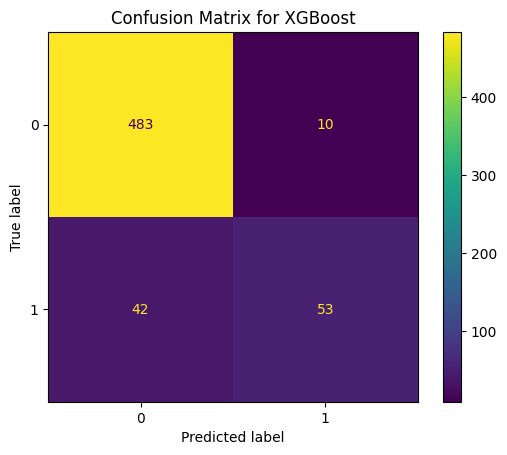

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# This model uses default hyperparameters with support for categorical variables enabled.
xgb_classifier = xgb.XGBClassifier(
    n_estimators=100,  # Number of trees (boosting rounds)
    objective='binary:logistic',  # Binary classification
    tree_method='hist',
    eta=0.1,  # Learning rate to control the contribution of each tree
    max_depth=3,  # Maximum depth of each tree
    enable_categorical=True,
    random_state=seed  # Fixed seed for reproducibility
)

# Fit the model to the training data.
xgb_classifier.fit(X_train, y_train)


# Predict the target variable for the test dataset.
y_pred = xgb_classifier.predict(X_test)


# Calculate accuracy and balanced accuracy to assess model performance.
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

# Display basic results
print("XGBoost Optimized with Default Hyperparameters and Categorical Support:")
print(f"Accuracy: {accuracy:.2f}")  # Standard accuracy metric
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")  # Balanced metric for imbalanced datasets


# Provides detailed performance metrics (precision, recall, F1-score) for each class.
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Confusion matrix visualization for true vs predicted classes.
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_classifier.classes_)
disp.plot(cmap='viridis')  # Use a visually appealing colormap
plt.title("Confusion Matrix for XGBoost")
plt.show()





The decision to implement XGBoosting as an additional model stems from its origins in Gradient Boosting, leveraging ensemble-based trees to enhance processing speed and improve model robustness compared to basic methods. One of the key advantages of XGBoost is its ability to handle categorical variables directly, without requiring preprocessing. However, it is significantly more complex than previously applied models.

In this case, we used the default hyperparameters.

The model achieved a balanced accuracy of 77%, indicating overall performance, but it struggles to predict the minority class. For the minority class (1 - "Employees who leave"), only 56% are correctly identified, with an F1-score of 67%, which evaluates both precision and the model's ability to correctly identify the class of interest. This reflects moderate performance, as the model has a high number of false negatives.

The confusion matrix highlights this issue:

For Class 0 ("Do not leave"), all cases were correctly predicted.
However, for Class 1 ("Leave"), there were 42 false negatives, meaning these employees were predicted as not leaving when they actually did.
These results suggest that while XGBoost performs well overall, it requires further optimization or adjustments to improve its ability to capture the minority class.
